In [1]:
import pandas as pd
import numpy as np
import toad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import my_model_lib as my_lib
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import scorecardpy as sc
# https://toad.readthedocs.io/en/latest/tutorial_chinese.html
import warnings
warnings.filterwarnings("ignore")

In [2]:
target = 'target'
to_drop = []
train_date = ['202210', '202211', '202212']
# train_date = ['202211', '202212']
oot_date = ['202301']


data = pd.read_csv('/Users/apple/Desktop/target2.csv')
data['target'] = data['target'].replace({'good': 0, 'bad': 1})
# data = data.drop(columns = to_drop)

# 只保留1个省

data['fill_bill_date'] = data['fill_bill_date'].astype(str)
data['dep_prov_no'] = data['dep_prov_no'].astype(str)
data['usr_job'] = data['usr_job'].astype(str)
data['schooling'] = data['schooling'].astype(str)
data = data[data['dep_prov_no'] == '22']

data.head(3)

,fill_bill_date,pkg_amt,loan_amt,dep_prov_no,pkg_typ,in_come,usr_job,schooling,marital_sta,gender,...,ylzc327,ylzc091,ylzc297,ylzc140,ylzc018,ylzc272,ylzc097,ylzc048,score,target
2,202210,71,750,22,1,3,6.0,4,1,女,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.01,0
7,202210,0,950,22,1,3,6.0,4,1,男,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.32,0
11,202210,0,750,22,1,3,6.0,6,1,女,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0


In [3]:

# 保留最后一列，修改其他列的列名为 X_1、X_2、X_3...
# columns_mapping = {}
# for i, col in enumerate(data.columns[:-1]):
#     new_col = 'X_' + str(i+1)
#     columns_mapping[col] = new_col
#     data.rename(columns={col: new_col}, inplace=True)

# print("DataFrame after renaming:")
# print(data)
# 
# print("\nMapping of original column names to new column names:")
# print(columns_mapping)

# 
columns = list(data.columns)
columns[:-1] = ['X_' + str(i+1) for i in range(len(data.columns)-1)]
data.columns = columns
# 最后一列X_205
# columns

In [4]:
# 合并age_marital_combined
age_bins = [28, 33, 39, 42, 46, 50, 53]
age_labels = ['1', '2', '3', '4', '5', '6']  # 定义年龄组标签
data['age_binned'] = pd.cut(data['X_11'], bins=age_bins, labels=age_labels, right=False)# 定义年龄组边界
data['X_206'] = data['age_binned'].astype(str) + "_M" + data['X_9'].astype(str)
data = data.drop(columns = ['X_9','X_11','age_binned','X_3'])

# 
# # 不稳定删除
# data = data.drop(columns = ['dep_prov_no'])



In [5]:
train_data = data[data['X_1'].isin(train_date)]
oot_data = data[data['X_1'].isin(oot_date)]

train_data = train_data.drop(columns = to_drop)
oot_data = oot_data.drop(columns = to_drop)
# train_data.shape,oot_data.shape

# 将数据分割成训练集的比例 44 不错
train_set, test_set = train_test_split(train_data, test_size=0.2, random_state=55,stratify=train_data[target])


print('train_set:',train_set.shape,",test_set:",test_set.shape,",oot_set:",oot_data.shape)

print('train_set_good_bad_num',train_set.groupby(target)[target].count())
print('test_set_good_bad_num',test_set.groupby(target)[target].count())
print('oot_set_good_bad_num',oot_data.groupby(target)[target].count())
detect_train = toad.detect(train_set)
detect_train

train_set: (25711, 204) ,test_set: (6428, 204) ,oot_set: (9361, 204)
train_set_good_bad_num target
0    24773
1      938
Name: target, dtype: int64
test_set_good_bad_num target
0    6194
1     234
Name: target, dtype: int64
oot_set_good_bad_num target
0    9011
1     350
Name: target, dtype: int64


,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
X_1,object,25711,0.00%,3,202211:35.36%,202210:33.01%,202212:31.63%,None,None,None,None,202211:35.36%,202210:33.01%,202212:31.63%
X_2,int64,25711,0.00%,51,64.817588,70.755792,0.0,0.0,0.0,64.0,111.0,166.0,238.0,421.0
X_4,object,25711,0.00%,1,22:100.00%,None,None,None,None,None,None,None,None,22:100.00%
X_5,int64,25711,0.00%,1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
X_6,int64,25711,0.00%,7,3.223912,1.251556,1.0,1.0,2.0,3.0,4.0,5.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X_203,float64,25711,99.96%,2,0.111111,0.333333,0.0,0.0,0.0,0.0,0.0,0.2,0.92,1.0
X_204,float64,25711,99.96%,3,0.555556,1.333333,0.0,0.0,0.0,0.0,0.0,1.6,3.76,4.0
X_205,float64,25711,0.22%,5426,56.475455,35.700995,0.0,0.0,0.0,69.29,86.67,93.69,98.8747,99.99
target,int64,25711,0.00%,2,0.036482,0.187491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [6]:
np.str = np.str_
# # toad.quality(data,target,cpu_cores=1,iv_only=True)
# 
# 
# huace_col = ['tsjy004','tsjy007','tsjy010','tsjy014','tsjy002','tsjy005','tsjy008','tsjy011','rms002','ylzc282','ylzc014','ylzc241','ylzc009','ylzc260','ylzc296','ylzc240','ylzc010','ylzc261','ylzc019','ylzc035','ylzc036','ylzc118','ylzc119','tsjy043','ylzc011','ylzc293','ylzc029','ylzc171','ylzc168','ylzc300','ylzc143','ylzc173','ylzc172','ylzc169','ylzc037','ylzc298','tsjy042','ylzc017','ylzc095','ylzc079','ylzc399','tsjy047','ylzc440','ylzc049','ylzc327','ylzc091','ylzc297','ylzc140','ylzc018','ylzc272','ylzc097',
#              'ylzc048',target]
# huace_exclude = ['tsjy008']
# # 
# toad.quality(data[huace_col],target,cpu_cores=1,iv_only=True)
# 过滤掉华策 iv值低的，剩7个
# huace_selected, dropped = toad.selection.select(data[huace_col],target = target, iv = 0.04,return_drop=True,  exclude=[])
# 
# huace_selected.corr()

In [7]:
train_selected, dropped = toad.selection.drop_empty(train_set,threshold = 0.8, return_drop=True)
print('删除缺失值多的变量-后',train_selected.shape)

train_selected, dropped = toad.selection.drop_iv(train_selected,threshold = 0.05,return_drop=True,target = target)
print('删除低iv的变量-后',train_selected.shape)

# 
train_selected, dropped = toad.selection.drop_corr(train_selected,threshold = 0.5, return_drop=True,target = target)
print('删除相关性高的变量-后',train_selected.shape)


删除缺失值多的变量-后 (25711, 148)
删除低iv的变量-后 (25711, 100)
删除相关性高的变量-后 (25711, 21)


In [8]:
# # 使用 select_dtypes 来仅保留数值类型的列
vif_train_selected = train_selected.select_dtypes(include=[np.number]).drop(columns = target)
vif_train_selected.corr()

,X_2,X_14,X_34,X_37,X_60,X_62,X_67,X_77,X_98,X_144,X_146,X_147,X_148,X_150,X_151,X_152,X_205
X_2,1.000000,0.175119,0.168241,0.077877,0.085620,0.143802,0.185044,0.098958,0.079986,0.046852,0.052772,0.032411,0.035951,0.036320,0.040749,-0.001173,0.140413
X_14,0.175119,1.000000,0.354754,0.242740,0.242934,0.416513,0.479556,0.189632,0.397796,0.048885,0.043353,0.038683,0.025853,0.006981,0.030757,0.068321,0.003828
X_34,0.168241,0.354754,1.000000,0.450228,0.293743,0.464527,0.409737,0.461088,0.478172,0.021245,0.025285,0.045368,0.035134,0.018581,0.005545,0.034290,0.056784
X_37,0.077877,0.242740,0.450228,1.000000,0.396799,0.475117,0.294519,0.418043,0.334132,0.022074,0.021392,0.025933,0.042187,0.018932,0.019041,0.011732,-0.033974
X_60,0.085620,0.242934,0.293743,0.396799,1.000000,0.481124,0.251809,0.327305,0.320778,0.032654,0.012584,0.006654,0.014474,0.007897,0.043969,0.031722,-0.023662
X_62,0.143802,0.416513,0.464527,0.475117,0.481124,1.000000,0.440568,0.387959,0.472217,0.057283,0.037128,0.041565,0.049807,0.017891,0.051412,0.060154,-0.043716
X_67,0.185044,0.479556,0.409737,0.294519,0.251809,0.440568,1.000000,0.225906,0.351701,0.026926,0.032155,0.044611,0.029389,0.011281,0.029443,0.042322,0.007211
X_77,0.098958,0.189632,0.461088,0.418043,0.327305,0.387959,0.225906,1.000000,0.296645,0.001608,0.001671,0.019068,0.023217,0.014052,0.013248,0.025361,0.017609
X_98,0.079986,0.397796,0.478172,0.334132,0.320778,0.472217,0.351701,0.296645,1.000000,0.019437,0.028968,0.027676,0.035723,0.004582,0.020366,0.021774,-0.026801
X_144,0.046852,0.048885,0.021245,0.022074,0.032654,0.057283,0.026926,0.001608,0.019437,1.000000,0.443991,0.090232,0.079736,0.053507,0.094825,0.063186,-0.104870


In [9]:
iv_train_selected = toad.quality(train_selected,target,cpu_cores=1,iv_only=True)
iv_train_selected.index.names = ["feature"]
detect_train.index.names = ["feature"]
# 
# 删除 marital_sta变量后
# train_data = vif_train_selected.drop(columns = 'marital_sta')

# vif_train_selected.head(3)
dff = add_constant(vif_train_selected)
# vif_train_selected = vif_train_selected[['pkg_amt', 'loan_amt', 'marital_sta','age']]
vif_train_selected = vif_train_selected.dropna()
# VIF dataframe 
vif_data = pd.DataFrame()
vif_data["feature"] = vif_train_selected.columns
# calculating VIF for each feature 
vif_data["vif"] = [variance_inflation_factor(vif_train_selected.values, i)
                   for i in range(len(vif_train_selected.columns))]
# vif_data


# iv_train_selected.rename(columns={np.nan:"feature"}, inplace=True)
# iv_train_selected
# iv_train_selected
# result = pd.concat([iv_train_selected,vif_data], axis=0)
# result
pd_mer_1 = pd.merge(iv_train_selected, vif_data, left_on='feature',right_on='feature',how='left')
pd_mer_2 = pd.merge(pd_mer_1, detect_train[['missing','type']], left_on='feature',right_on='feature',how='left')
pd_mer_2[['feature','type','missing','unique','iv','vif']]


,feature,type,missing,unique,iv,vif
0,X_67,float64,0.22%,45.0,0.655746,1.945987
1,X_14,float64,0.22%,5.0,0.529509,1.755588
2,X_2,int64,0.00%,51.0,0.456218,2.047701
3,X_144,float64,50.73%,1512.0,0.425623,1.334396
4,X_206,object,0.00%,14.0,0.302750,NaN
5,X_152,float64,50.73%,9.0,0.279044,1.171649
6,X_205,float64,0.22%,5427.0,0.274191,2.116115
7,X_150,float64,50.73%,8.0,0.271809,1.202127
8,X_151,float64,50.73%,9.0,0.266491,1.177846
9,X_148,float64,50.73%,9.0,0.257987,1.384581


In [10]:
np.float = np.float64



c = toad.transform.Combiner()
# 使用特征筛选后的数据进行训练：使用稳定的卡方分箱，规定每箱至少有5%数据, 空值将自动被归到最佳箱。
# c.fit(train_selected, y = target, method = 'chi', min_samples = 0.05,empty_separate = True) #empty_separate = False

In [11]:

# 
missing_percentage = train_selected.isna().mean()
# 
# # 找出缺失值少于1%的列
low_missing_cols = missing_percentage[missing_percentage < 0.01].index.tolist()
high_missing_cols = missing_percentage[missing_percentage >= 0.01].index.tolist()
c.fit(train_selected[low_missing_cols], y = target, method = 'chi', min_samples = 0.05,empty_separate = False)
bin_mission_low = c.export()
c.fit(train_selected[high_missing_cols+[target]], y = target, method = 'chi', min_samples = 0.05,empty_separate = True)
bin_mission_high = c.export()
combined_dict = {**bin_mission_low, **bin_mission_high}
c.update(combined_dict)
combined_dict

{'X_2': [149],
 'X_7': [['19.0', '14.0', '1.0'],
  ['17.0', '21.0', '4.0', '2.0'],
  ['6.0', '16.0', 'nan'],
  ['5.0', '3.0', '9.0', '12.0'],
  ['8.0', '11.0', '13.0', '15.0', '7.0', '10.0', '20.0', '18.0']],
 'X_10': [['女'], ['男']],
 'X_14': [1.0],
 'X_34': [1.0],
 'X_37': [1.0],
 'X_60': [1.0],
 'X_62': [1.0],
 'X_67': [1.0, 2.0, 3.0, 6.0],
 'X_77': [],
 'X_98': [1.0],
 'X_205': [0.02, 77.07],
 'X_206': [['4_M1', '5_M1', '3_M1'],
  ['6_M1', '2_M1', 'nan_M1'],
  ['1_M1'],
  ['6_M0', '4_M0', '3_M0', '5_M0', 'nan_M0', '1_M0', '2_M0']],
 'X_144': [8740.0, nan],
 'X_146': [nan],
 'X_147': [1.0, nan],
 'X_148': [1.0, nan],
 'X_150': [4.0, nan],
 'X_151': [1.0, nan],
 'X_152': [1.0, 3.0, nan]}

In [12]:

# 将数据展平，以便可以创建 DataFrame
# 此步骤需要根据数据结构的复杂性进行适当调整
# 列表用于存储转换后的数据
formatted_data = []
bins = c.export()
# 遍历字典，处理每个键值对
for key, values in bins.items():
    # 检查值是否为列表，如果是，将列表转换为字符串
    if isinstance(values, list):
        # 将嵌套列表转换为单个字符串
        value_str = '; '.join([','.join(map(str, sublist)) if isinstance(sublist, list) else str(sublist) for sublist in values])
    else:
        value_str = str(values)
    # 添加到列表中
    formatted_data.append((key, value_str))

# 创建 DataFrame
df = pd.DataFrame(formatted_data, columns=['Key', 'Value'])
# df
bins

{'X_144': [8740.0, nan],
 'X_146': [nan],
 'X_147': [1.0, nan],
 'X_148': [1.0, nan],
 'X_150': [4.0, nan],
 'X_151': [1.0, nan],
 'X_152': [1.0, 3.0, nan],
 'X_2': [149],
 'X_7': [['19.0', '14.0', '1.0'],
  ['17.0', '21.0', '4.0', '2.0'],
  ['6.0', '16.0', 'nan'],
  ['5.0', '3.0', '9.0', '12.0'],
  ['8.0', '11.0', '13.0', '15.0', '7.0', '10.0', '20.0', '18.0']],
 'X_10': [['女'], ['男']],
 'X_14': [1.0],
 'X_34': [1.0],
 'X_37': [1.0],
 'X_60': [1.0],
 'X_62': [1.0],
 'X_67': [1.0, 2.0, 3.0, 6.0],
 'X_77': [],
 'X_98': [1.0],
 'X_205': [0.02, 77.07],
 'X_206': [['4_M1', '5_M1', '3_M1'],
  ['6_M1', '2_M1', 'nan_M1'],
  ['1_M1'],
  ['6_M0', '4_M0', '3_M0', '5_M0', 'nan_M0', '1_M0', '2_M0']]}

In [13]:
from toad.plot import bin_plot


# loan_amt  0.037
# usr_job 0.039
# marital_sta 0.169
# gender 0.07
# age 0.189
# p2p_60m 0.433
# consumption_finance_large_18m_id_card 0.029
# abnormal_loan_low_flag 0.09
# education_90d 0.42
# tsjy005 0.03
# score 0.13

# 蓝色bar代表了样本量占比，
# 红线代表了正样本占比（e.g. 坏账率），也就是target的汇总
# col = 'usr_job'
# data = c.transform(train_selected[[key,target]],labels = True)
# grouped = my_lib.calculate_bin_woe_id(key,data);

# 列表保存每个变量的结果
results = []
for key, values in bins.items():
    data = c.transform(train_selected[[key,target]],labels = True)
    grouped = my_lib.calculate_bin_woe_id(key,data);
    results.append(grouped)
final_result = pd.concat(results)
final_result
# results  
# pd.option_context('mode.use_inf_as_na', True)
# bin_plot(c.transform(train_selected[[col,target]], labels=True), x=col, target=target)

# toad.quality(train_selected,target,cpu_cores=1,iv_only=True)

,total,bad,good,bad_dist,good_dist,WOE,IV,feature
00.[-inf ~ 8740.0),10225,159,10066,0.169510,0.406329,-0.874255,0.207041,X_144
01.[8740.0 ~ inf),2444,42,2402,0.044776,0.096960,-0.772628,0.040319,X_144
02.nan,13042,737,12305,0.785714,0.496710,0.458587,0.132533,X_144
00.[-inf ~ inf),12669,201,12468,0.214286,0.503290,-0.853856,0.246768,X_146
01.nan,13042,737,12305,0.785714,0.496710,0.458587,0.132533,X_146
00.[-inf ~ 1.0),11928,187,11741,0.199360,0.473943,-0.865974,0.237782,X_147
01.[1.0 ~ inf),741,14,727,0.014925,0.029346,-0.676109,0.009750,X_147
02.nan,13042,737,12305,0.785714,0.496710,0.458587,0.132533,X_147
00.[-inf ~ 1.0),11905,184,11721,0.196162,0.473136,-0.880442,0.243860,X_148
01.[1.0 ~ inf),764,17,747,0.018124,0.030154,-0.509092,0.006124,X_148


In [14]:
# 初始化
transer = toad.transform.WOETransformer()
# combiner.transform() & transer.fit_transform() 转化训练数据，并去掉target列
train_woe = transer.fit_transform(c.transform(train_selected), train_selected[target], exclude=[target])
# test_woe = transer.fit_transform(c.transform(test_set[train_selected.columns]), test_set[target], exclude=[target])
# oot_woe = transer.fit_transform(c.transform(oot_data[train_selected.columns]), oot_data[target], exclude=[target])


# 初始化
transer = toad.transform.WOETransformer()

# combiner.transform() & transer.fit_transform() 转化训练数据，并去掉target列
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['target'], exclude=to_drop+['target'])
test_woe = transer.transform(c.transform(test_set[train_selected.columns]))
oot_woe = transer.transform(c.transform(oot_data[train_selected.columns]))

toad.metrics.PSI(train_woe, oot_woe)

# toad.metrics.PSI(train_woe, test_woe)
# test_woe
# train_woe.shape,test_woe.shape,oot_woe.shape
# print(train_woe.loan_amt.value_counts())
# oot_woe.head(5)
# print(train_woe.head(3))
# print(oot_woe.head(3))

X_2       0.026087
X_7       0.001321
X_10      0.004025
X_14      0.001667
X_34      0.004071
X_37      0.014149
X_60      0.002952
X_62      0.000488
X_67      0.006165
X_77      0.000000
X_98      0.000903
X_144     0.004367
X_146     0.003998
X_147     0.004458
X_148     0.004048
X_150     0.006340
X_151     0.005806
X_152     0.004111
X_205     0.004559
target    0.000023
X_206     0.000908
dtype: float64

In [15]:
# 将woe转化后的数据做逐步回归
final_data = toad.selection.stepwise(train_woe,target = target, estimator='ols', direction = 'both', criterion = 'aic', exclude = [])
final_data.columns
# c.export()['pkg_amt']

Index(['X_2', 'X_7', 'X_10', 'X_37', 'X_67', 'X_146', 'X_205', 'target',
       'X_206'],
      dtype='object')

In [16]:
# 将选出的变量应用于test/OOT数据
final_test_data = test_woe[final_data.columns]
final_oot_data = oot_woe[final_data.columns]
final_data.shape,final_test_data.shape,final_oot_data.shape


((25711, 9), (6428, 9), (9361, 9))

In [17]:
# 确定建模要用的变量
col = list(final_data.drop([target],axis=1).columns)
# final_data
# final_data.shape,final_test_data.shape,final_oot_data.shape
toad.metrics.PSI(final_data[col], final_oot_data[col])

X_2      0.026087
X_7      0.001321
X_10     0.004025
X_37     0.014149
X_67     0.006165
X_146    0.003998
X_205    0.004559
X_206    0.000908
dtype: float64

In [18]:
from sklearn.linear_model import LogisticRegression


In [19]:
# 用逻辑回归建模
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')

# 假设final_data是你的DataFrame，col是特征列的列表，target是目标变量列的名字
X = final_data[col]
y = final_data[target]
# 添加常数项以拟合截距
# X = sm.add_constant(X)
# 拟合逻辑回归模型
# model = sm.Logit(y, X)
# result = model.fit()
# 输出摘要，其中包括系数、标准误差、z值、p值、Wald卡方等
# print(result.summary())

In [20]:

lr.fit(X,y)
# 获取系数和截距
coefficients = lr.coef_
intercept = lr.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

# 添加常数项以拟合截距
# Coefficients: [[ 0.81827825  0.65060785  0.64213523 -0.34358324  0.76755261  0.59512749
#                  0.97275512  0.68138303]]
# Intercept: [-3.2651437]
# 添加常数项以拟合截距

Coefficients: [[ 0.6637013   0.54693587  0.58573175 -0.36571845  0.77931151  0.66594987
   0.98866619  0.64148223]]
Intercept: [0.00459559]


In [31]:

# 1 取bad概率
pred_train = lr.predict_proba(final_data[col])[:,1]
pred_test =lr.predict_proba(final_test_data[col])[:,1]
pred_oot =lr.predict_proba(final_oot_data[col])[:,1]
from toad.metrics import KS, AUC
print('train KS',KS(pred_train, final_data[target]))
print('train AUC',AUC(pred_train, final_data[target]))

print('test KS',KS(pred_test, final_test_data[target]))
print('test AUC',AUC(pred_test, final_test_data[target]))

print('oot KS',KS(pred_oot, final_oot_data[target]))
print('oot AUC',AUC(pred_oot, final_oot_data[target]))

print('test PSI',my_lib.calculate_model_psi(pred_train, pred_test))
print('oot PSI',my_lib.calculate_model_psi(pred_train, pred_oot))
print('oot PSI',my_lib.calculate_model_psi(pred_train, pred_oot))

my_lib.calculate_interval_psi(pred_train, pred_oot)
# train KS 0.4404545512055434
# train AUC 0.7930267812548173
# test KS 0.4412017143692959
# test AUC 0.7752270600995173
# oot KS 0.4252529448134819
# oot AUC 0.7725679724780823
# test PSI 0.0023421484667919597
# oot PSI 0.0037099803424554038

train KS 0.4404545512055434
train AUC 0.7930267812548173
test KS 0.4412017143692959
test AUC 0.7752270600995173
oot KS 0.4252529448134819
oot AUC 0.7725679724780823
test PSI 0.0023421484667919597
oot PSI 0.0037099803424554038
oot PSI 0.0037099803424554038


,Breakpoint Start,Breakpoint End,Expected Proportion,Actual Proportion,Interval PSI
0,0.056035,0.136979,0.099685,0.090589,0.000870
1,0.136979,0.174612,0.099763,0.097639,0.000046
2,0.174612,0.226151,0.100502,0.097319,0.000102
3,0.226151,0.274821,0.091906,0.089520,0.000063
4,0.274821,0.344921,0.107036,0.115693,0.000673
5,0.344921,0.419359,0.099879,0.106719,0.000453
6,0.419359,0.480164,0.101085,0.110458,0.000831
7,0.480164,0.559321,0.099879,0.102233,0.000055
8,0.559321,0.707252,0.100152,0.096571,0.000130
9,0.707252,0.978973,0.100113,0.093259,0.000486


In [22]:
# final_data[target].values
pred_train

array([0.13566129, 0.27482115, 0.18913809, ..., 0.79137323, 0.42072546,
       0.30602134])

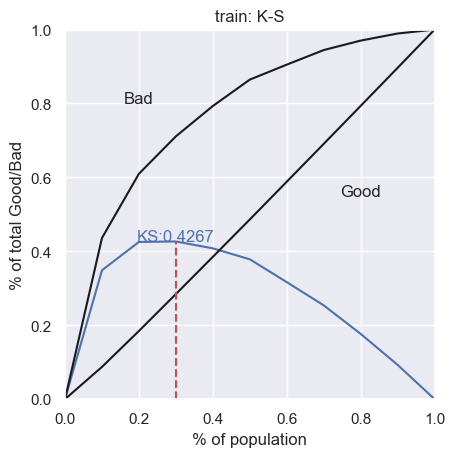

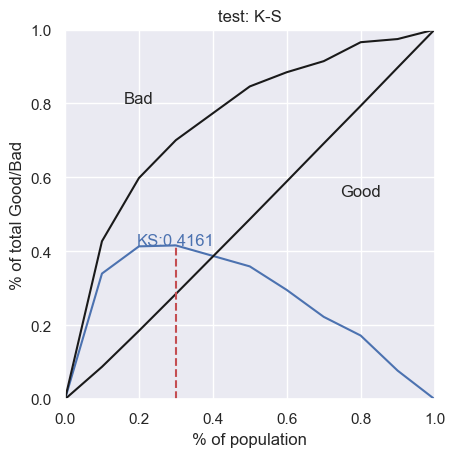

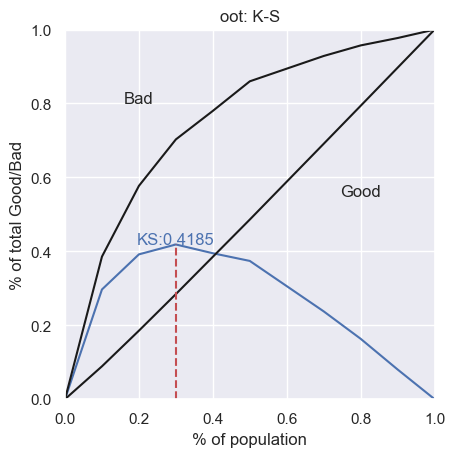

{'KS': 0.4185, 'pic': <Figure size 640x480 with 1 Axes>}

In [51]:

import scorecardpy as sc
# auc和ks值可视化输出
sc.perf_eva( final_data[target].values,pred_train,plot_type=["ks"],groupnum=10,title="train")
# sc.perf_eva( final_data[target].values,pred_train,plot_type=["roc"])
sc.perf_eva( final_test_data[target].values,pred_test,plot_type=["ks"],groupnum=10,title="test")
sc.perf_eva( final_oot_data[target].values,pred_oot,plot_type=["ks"],groupnum=10,title="oot")



In [25]:

# 计算并输出结果
interval_psi_table = my_lib.calculate_interval_psi(pred_train, pred_oot, buckets=10)
interval_psi_table
# pred_test

,Breakpoint Start,Breakpoint End,Expected Proportion,Actual Proportion,Interval PSI
0,0.056035,0.136979,0.099685,0.090589,0.000870
1,0.136979,0.174612,0.099763,0.097639,0.000046
2,0.174612,0.226151,0.100502,0.097319,0.000102
3,0.226151,0.274821,0.091906,0.089520,0.000063
4,0.274821,0.344921,0.107036,0.115693,0.000673
5,0.344921,0.419359,0.099879,0.106719,0.000453
6,0.419359,0.480164,0.101085,0.110458,0.000831
7,0.480164,0.559321,0.099879,0.102233,0.000055
8,0.559321,0.707252,0.100152,0.096571,0.000130
9,0.707252,0.978973,0.100113,0.093259,0.000486


In [44]:
# 将预测等频分箱，观测每组的区别
toad.metrics.KS_bucket(pred_train, final_data[target], bucket=10)
print('train KS',KS(pred_train, final_data[target]))


train KS 0.4404545512055434


In [27]:
# toad.metrics.KS_bucket(lr.predict_proba(final_data[col])[:,0], final_data['target'], bucket=10, method = 'quantile')

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,...,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.021027,0.292613,408,2150,2558,0.159500,0.840500,0.189767,0.434968,0.086788,...,0.036482,0.434968,1.000000,0.086788,1.000000,0.099490,1.000000,0.348180,4.371956,4.371956
1,0.292748,0.440210,164,2418,2582,0.063517,0.936483,0.067825,0.174840,0.097606,...,0.022891,0.609808,0.565032,0.184394,0.913212,0.199914,0.900510,0.425414,1.741020,3.050346
2,0.440679,0.519302,95,2474,2569,0.036979,0.963021,0.038399,0.101279,0.099867,...,0.017792,0.711087,0.390192,0.284261,0.815606,0.299833,0.800086,0.426826,1.013621,2.371614
3,0.519836,0.580292,74,2374,2448,0.030229,0.969771,0.031171,0.078891,0.095830,...,0.015054,0.789979,0.288913,0.380091,0.715739,0.395045,0.700167,0.409887,0.828584,1.999719
4,0.580641,0.655040,69,2603,2672,0.025823,0.974177,0.026508,0.073561,0.105074,...,0.012666,0.863539,0.210021,0.485165,0.619909,0.498969,0.604955,0.378374,0.707830,1.730646
5,0.655079,0.724620,39,2542,2581,0.015110,0.984890,0.015342,0.041578,0.102612,...,0.009936,0.905117,0.136461,0.587777,0.514835,0.599354,0.501031,0.317340,0.414183,1.510154
6,0.725179,0.773456,37,2486,2523,0.014665,0.985335,0.014883,0.039446,0.100351,...,0.008640,0.944563,0.094883,0.688128,0.412223,0.697484,0.400646,0.256435,0.401976,1.354244
7,0.773849,0.825042,23,2550,2573,0.008939,0.991061,0.009020,0.024520,0.102935,...,0.006686,0.969083,0.055437,0.791063,0.311872,0.797557,0.302516,0.178020,0.245021,1.215064
8,0.825388,0.862647,18,2423,2441,0.007374,0.992626,0.007429,0.019190,0.097808,...,0.005572,0.988273,0.030917,0.888871,0.208937,0.892497,0.202443,0.099402,0.202125,1.107312
9,0.863021,0.943965,11,2753,2764,0.003980,0.996020,0.003996,0.011727,0.111129,...,0.003980,1.000000,0.011727,1.000000,0.111129,1.000000,0.107503,0.000000,0.109086,1.000000


In [31]:

card = toad.ScoreCard(
    combiner = c,
    transer = transer,
    class_weight = 'balanced',
    # C=0.1,
    base_score = 750,
    base_odds = 20 ,
    pdo = 50,
    rate = 2
)

card.fit(final_data[col], final_data['target'])

ScoreCard(base_odds=20,
          combiner=<toad.transform.Combiner object at 0x149c14e90>, pdo=50,
          transer=<toad.transform.WOETransformer object at 0x149c14a50>)

In [32]:
# card.export()
l_box_name = []
l_box_value = []
l_box_score = []
for key in card.export().keys():
    for box_value in card.export().get(key):
        l_box_name.append(key)
        #         print(box_value)
        l_box_value.append(box_value)
        #         print(card.export().get(key).get(box_value))
        l_box_score.append(card.export().get(key).get(box_value))

score_card = pd.DataFrame({'box_name':l_box_name,'box_value':l_box_value,'box_score':l_box_score})
score_card.head(100)


,box_name,box_value,box_score
0,X_2,[-inf ~ 149),76.87
1,X_2,[149 ~ inf),24.52
2,X_7,"19.0,14.0,1.0",81.93
3,X_7,"17.0,21.0,4.0,2.0",71.87
4,X_7,"6.0,16.0,nan",66.14
5,X_7,"5.0,3.0,9.0,12.0",61.91
6,X_7,"8.0,11.0,13.0,15.0,7.0,10.0,20.0,18.0",49.84
7,X_10,女,92.44
8,X_10,男,56.11
9,X_37,[-inf ~ 1.0),65.39


In [33]:
# 直接使用原始数据进行评分
score_train = card.predict(train_set)
# train_set[['X_2','X_7','X_10','X_37','X_67','X_146','X_205','X_206','target']].head(2)


In [34]:

score_train

array([667.48298116, 603.89578573, 638.90441137, ..., 437.73189531,
       556.97200116, 592.96654653])

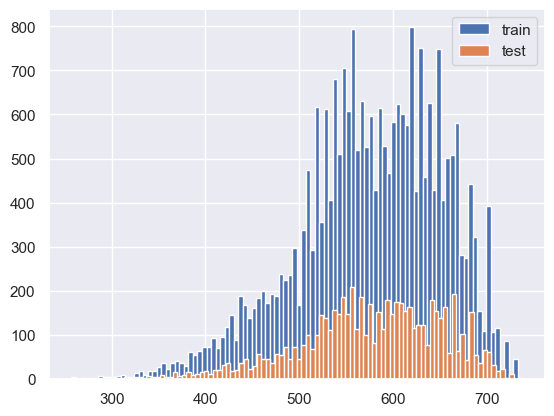

In [35]:

score_test = card.predict(test_set)
import matplotlib.pyplot as plt
# 
plt.hist(score_train, label = 'train', bins = 100)
plt.hist(score_test, label = 'test', bins = 100)
plt.legend()
plt.show()

In [36]:
plt.hist(my_lib.calculate_model_psi[train_selected.target == 0], label = 'good', bins = 50)
plt.hist(my_lib.calculate_model_psi[train_selected.target == 1], label = 'bad', bins = 50)
plt.legend()
plt.show()

TypeError: 'function' object is not subscriptable

In [ ]:
# pred_train
# 使用matplotlib绘制直方图
plt.figure(figsize=(10, 6))  # 设置图形的大小
plt.hist(pred_train, bins=20, alpha=0.75, color='blue', edgecolor='black')  # 绘制直方图
plt.title('Distribution of Good User Probabilities')  # 设置图形标题
plt.xlabel('Probability')  # 设置x轴标签
plt.ylabel('Frequency')  # 设置y轴标签
plt.grid(True)  # 显示网格
plt.show()  # 显示图形

In [ ]:
final_data[target].values
# sc.perf_eva( final_data[target].values,pred_train)
